In [14]:
import torch
from PIL import Image
from torchvision import transforms
from pathlib import Path
# from torchvision.models.vision_transformer import vit_b_16
from torch import nn
# from torchvision.models import vit_b_16
from torchvision.models import vit_b_16, ViT_B_16_Weights
import faiss
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
import gradio as gr

# Variabels used  in search_faiss_index function.
top_k = None  # Number of top results to retrieve.
nprobe = None # Number of clusters to search in FAISS index.


In [15]:

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [16]:
transform = transforms.Compose([
    transforms.Resize((224)),# Resize the shorter side to 224 pixels
    transforms.CenterCrop(224),
    transforms.ToTensor(),    #to convert image to tensor CxHxW
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]) # Normalization values of ImageNet 
])

def preprocess_image(image_path):
    img= Image.open(image_path).convert("RGB") #conversion of image to RGB
    original_size = img.size #width, height
    img_tensor = transform(img)
    metadata= {    
        "path":str(image_path),#storing path of image
        "original_size": original_size,
        "processed_shape": img_tensor.shape,
        "processed_dtype": str(img_tensor.dtype),
        "processed_device": str(img_tensor.device)       
    }
    return img_tensor, metadata
# accessing all images in the directory
def preprocess_images_in_folder(folder_path):
    print("inside the  preprocess_images_in_folder function")
    folder= Path(folder_path)
    # adjust the extensions as needed
    # image_paths= list(folder.glob("*.jpg")) + list(folder.glob("*.png")) + list(folder.glob("*.jpeg")) + list(folder.glob("*.webp"))
    image_paths = [p for p in folder.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".webp"]]

    if not image_paths:
        print(f"NO images found in: {folder_path}")
        
    all_tensors = []
    all_metadata = []
    # print(f"Found {len(image_paths)} images in {folder_path}")
    for img_path in image_paths:
        # print("inside the for loop")
        tensor, metadata = preprocess_image(img_path)
        all_tensors.append(tensor)
        all_metadata.append(metadata)
        
    print(f"Completed preprocessing {len(all_tensors)} images in {folder_path}")    
    return all_tensors, all_metadata
#after completion of this function it returns tensors of all images and metadata of all images
# Tensors used as input to vit , metadata used for displaying the results

In [17]:
# Load the Vision Transformer model- pre trained model

def load_vit_model():
    print("Loading the Vision Transformer model... This may take a moment. load_vit_model function")
    model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
    # Remove the classification head to get feature vectors
    model.heads = nn.Identity()  # Replace classification head with identity to get features
    model.eval()  # Set to eval mode
    print("Model loaded successfully. and returned")
    return model


# feature extraction fuction
def extract_features(model, tensors):
    print("Extracting features from images... extract_features function....takes model and tensors ")
    features = []
    i=0
    with torch.no_grad():  # No gradients needed for feature extraction
        for img_tensor in tensors:
            i=i+1
            print(f'Images No. to extract features from:  {i} out of {len(tensors)}')
            img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension: [1, 3, 224, 224]
            feature = model(img_tensor)  # Output shape: [1, 768]
            features.append(feature.squeeze(0))  # Remove batch dimension
            
    print(f"features extracted for {len(features)} images... extract_features function")
    return features  # List of feature tensors


# save the model to a file
def save_model(model, path="vit_b16_feature_extractor.pth"):
    print(f"Saving the model to {path}... save_model function")
    torch.save(model.state_dict(), path)
    
    

# load the saved model
def load_saved_model(path="vit_b16_feature_extractor.pth"):
    print(f"loading the saved model from {path}... load_saved_model function")
    # model = vit_b_16(pretrained=False)
    model = vit_b_16(weights = None)  # Load the pre-trained weights  
    model.heads=nn.Identity()  # Replace classification head with identity
    model.load_state_dict(torch.load(path, map_location=torch.device("cpu")))
    model.eval()  # Set to eval mode
    print("Model loaded successfully from the file. load_saved_model function")
    return model

In [18]:
# evauation
def evaluate_feature_extractor(model, sample_tensor):
    print("Evaluating the feature extractor with a sample tensor... evaluate_feature_extractor function")
    model.eval()
    with torch.no_grad():
        sample_tensor = sample_tensor.unsqueeze(0)  # Add batch dimension
        features = model(sample_tensor)
        print(f"Extracted feature shape: {features.shape}")  # Should be [1, 768]

In [19]:
# def create_faiss_index(features, nlist=2):
#     # nlist means number of clusters or lists in the index
#     print("Creating FAISS index... create_faiss_index function")
#     feature_matrix = torch.stack(features).cpu().numpy().astype("float32")  # Convert to numpy array
#     print("converted features to numpy array")
#     d = feature_matrix.shape[1]
#     print(f"Feature dimension: {d}")
#     if d == 0:
#         raise ValueError("Feature dimension is zero. Ensure features are extracted correctly.")     
    
#     quantizer = faiss.IndexFlatL2(d) # quantizer for ivf index
#     index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
#     print(f"FAISS index created with {nlist} lists.")
 
#     # Train the index with the feature matrix is important
#     index.train(feature_matrix) # necessary step for IVF index
#     index.add(feature_matrix)  # Add the feature vectors to the index
#     print(f"Index trained and {index.ntotal} vectors added.")
    
#     print(f"successfully created the faiss index with {nlist} lists.")
    
#     return index, feature_matrix

# cosine similarity based faiss index creation
def create_faiss_index(features, nlist=2):  # Increase nlist for better clustering
    print("Creating FAISS index using cosine similarity...")

    feature_matrix = torch.stack(features).cpu().numpy().astype("float32")

    # 🔁 Normalize the feature vectors to unit length for cosine similarity
    faiss.normalize_L2(feature_matrix)

    d = feature_matrix.shape[1]
    print(f"Feature dimension: {d}")
    # Use inner product for cosine similarity
    if d == 0:
        raise ValueError("Feature dimension is zero. Ensure features are extracted correctly.")
    quantizer = faiss.IndexFlatIP(d)  # ✅ Use Inner Product for cosine similarity
    index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

    index.train(feature_matrix)
    index.add(feature_matrix)

    print(f"FAISS index created with {nlist} clusters and {index.ntotal} vectors added.")
    return index, feature_matrix



# Save FAISS Index and Metadata
def save_faiss_index(index, index_path="faiss_ivf.index"):
    faiss.write_index(index, index_path)
    print(f"FAISS index saved to {index_path}")

def save_metadata(metadata_list, path="metadata.json"):
    with open(path, "w") as f:
        json.dump(metadata_list, f, indent=4)
    print(f"Metadata saved to {path}")
    
    

# Load FAISS Index and Metadata
def load_faiss_index(index_path="faiss_ivf.index"):
    print(f"Loading FAISS index from {index_path}... load_faiss_index function")
    return faiss.read_index(index_path)

def load_metadata(path="metadata.json"):
    print(f"Loading metadata from {path}... load_metadata function")
    with open(path, "r") as f:
        return json.load(f)

In [20]:
# preprocess query image
def preprocess_query_image(image_path):
    print(f"Preprocessing of query image")
    img_tensor, _ = preprocess_image(image_path)
    return img_tensor

In [21]:
## extract features from query image
# def extract_query_features(model,query_tensor):
#     print(f"Extracting features from query image")
#     model.eval()
#     with torch.no_grad():
#         query_tensor = query_tensor.unsqueeze(0)  # Add batch dimension
#         feature = model(query_tensor)  # Output shape: [1, 768]
#         feature_np = feature.squeeze(0).cpu().numpy().astype("float32")  # Remove batch dimension [768]
#         print(f"type(feature_np), feature_np.shape, feature_np.dtype: {type(feature_np)}, {feature_np.shape}, {feature_np.dtype}")
#         print(f"Extracted feature shape: {feature_np.shape}")  # Should be [768]
#         return feature_np
      
#For cosine
def extract_query_features(model, query_tensor):
    print(f"Extracting features from query image...")
    model.eval()
    with torch.no_grad():
        query_tensor = query_tensor.unsqueeze(0)
        feature = model(query_tensor)
        feature_np = feature.squeeze(0).cpu().numpy().astype("float32") #comment this line 

        # Normalize to unit length (L2) for cosine similarity
        faiss.normalize_L2(feature_np.reshape(1, -1)) #this 

        print(f"Extracted normalized feature shape: {feature_np.shape}")
        return feature_np



In [22]:
# function  generate_gradcam
def generate_gradcam_vit(model, input_tensor, target_layer="encoder.ln"):
    print("this is the GRAD_CAM function")
    print(f"Generating Grad-CAM for the input tensor using {target_layer} layer")

    # Container for gradients and activations
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        print("Forward hook triggered")
        activations['value'] = output.detach()

    def backward_hook(module, grad_in, grad_out):
        print("Backward hook triggered")
        gradients['value'] = grad_out[0].detach()

    # Get the layer from the model using the layer name
    try:
        target_module = dict([*model.named_modules()])[target_layer]
    except KeyError:
        raise ValueError(f"Layer {target_layer} not found in the model.")

    # Register the hooks
    forward_handle = target_module.register_forward_hook(forward_hook)
    backward_handle = target_module.register_backward_hook(backward_hook)

    # Forward pass
    input_tensor = input_tensor.unsqueeze(0)
    input_tensor.requires_grad_(True)
    output = model(input_tensor)  # shape: [1, 768]
    print(f"Output shape after forward pass: {output.shape}")

    # Create dummy target (pseudo target)
    target = output[0].mean()
    print(f"Target value for backward pass: {target.item()}")
    target.backward()
    print("Backward pass completed")

    # Check if hooks worked
    if 'value' not in activations or 'value' not in gradients:
        forward_handle.remove()
        backward_handle.remove()
        raise RuntimeError("Hooks did not fire. Ensure correct layer name is used.")

    # Get activations and gradients
    grads = gradients['value'][0]  # [tokens, channels]
    acts = activations['value'][0]  # [tokens, channels]

    weights = grads.mean(dim=0)  # [channels]
    print(f"Weights shape after global average pooling: {weights.shape}")

    cam = torch.matmul(acts, weights)  # [tokens]
    print(f"CAM shape after weighted combination: {cam.shape}")

    # Normalize and reshape
    cam =cam[1:]  # Exclude the CLS token
    cam = cam - cam.min()
    cam = cam / cam.max()
    cam = cam.reshape(1, int(cam.shape[0]**0.5), int(cam.shape[0]**0.5))  # [1, H, W]

    # Upsample to input size
    cam = F.interpolate(cam.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
    heatmap = cam.squeeze().detach().cpu().numpy()

    # Clean up
    forward_handle.remove()
    backward_handle.remove()

    print("Grad-CAM generation completed")
    return heatmap
# end 

def overlay_heatmap_on_image(image_path, heatmap, alpha=0.5):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (224, 224))  # Resize to match heatmap size
    heatmap = cv2.resize(heatmap, (224, 224))  # Resize heatmap to match image size
    heatmap = np.uint8(255 * heatmap)  # Normalize heatmap to [0, 255]
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap
    overlayed = cv2.addWeighted(img, alpha, heatmap_color, 1 - alpha, 0)  # Overlay heatmap on image
    return overlayed
# end

In [23]:
#Search function using the L2 distance metric in FAISS 

# def search_faiss_index(query_feature, index, metadata, top_k=5, nprobe=2):
#     index.nprobe = nprobe
#     distances, indices = index.search(np.array([query_feature]), top_k)

#     results = []  # ✅ This is correctly a list

#     for i, (idx, distance) in enumerate(zip(indices[0], distances[0])):
#         if idx < len(metadata):
#             meta = metadata[idx]
#             similarity_score = 1 / (1 + distance + 1e-8)  # Avoid division by zero
#             # there can be question on the similarity score , division by zero,if similarity is 100
#             result = {
#                 "rank": i + 1,
#                 "image_name": Path(meta["path"]).name,
#                 "image_path": meta["path"],
#                 "distance": float(distance),
#                 "similarity_score": float(similarity_score)
#             }
#             results.append(result)  # ✅ Appending to the list

#     print(f"Search completed. Found {len(results)} results.")
#     return results

# FOR COSINE SIMILARITY
def search_faiss_index(query_feature, index, metadata, top_k=top_k, nprobe=nprobe):
    index.nprobe = min(nprobe,index.nlist ) # 🔁 Increase nprobe for better recall
    
    # Normalize query for cosine similarity
    query_feature = query_feature.astype('float32') # Ensure query feature is float32 for FAISS compatibility
    faiss.normalize_L2(query_feature.reshape(1, -1))  # Normalize to unit length for cosine similarity
    
    distances, indices = index.search(np.array([query_feature]), top_k)

    results = []
    for i, (idx, score) in enumerate(zip(indices[0], distances[0])):
        if idx == -1 or idx >= len(metadata) or np.isnan(score) or np.isinf(score):
            print(f"Warning: Invalid result at rank {i+1}, skipping...")
            continue
        meta = metadata[idx]
        similarity_score = max(0.0, min(1.0, float(score)))

        # similarity_score =max(0.0, float(score))  # Cosine similarity ∈ [0, 1]
        # similarity_score= score
        distance = 1.0 - similarity_score  # Optional: interpret as cosine distance
        result = {
            "rank": len(results) + 1,  # Correct rank after filtering
            "image_name": Path(meta["path"]).name,
            "image_path": meta["path"],
            "similarity_score": similarity_score,
            "distance": distance
        
        }
        results.append(result)
    print(f"Search completed. Found {len(results)} results.")
    return results


def display_query_and_gradcam_results(query_image_path, top_k_results, model):
    fig, axes = plt.subplots(2, len(top_k_results) + 1, figsize=(20,6))
    
    # Query Image
    query_tensor, _ = preprocess_image(query_image_path)
    heatmap = generate_gradcam_vit(model, query_tensor)
    overlayed_query = overlay_heatmap_on_image(query_image_path, heatmap)
    # row 0 ,column 0 - query image(original image)
    axes[0,0].imshow(Image.open(query_image_path))
    axes[0,0].set_title("Query Image")
    axes[0,0].axis("off")
    # row 1, column 0 - query image with gradcam
    axes[1,0].imshow(overlayed_query[...,::-1])  # Convert BGR to RGB for display
    axes[1,0].set_title("Query Image with Grad-CAM")
    axes[1,0].axis("off")
    
    # Top K Results retrieved
    for i, result in enumerate(top_k_results):
        retrieved_tensor,_ = preprocess_image(result["image_path"])
        heatmap = generate_gradcam_vit(model, retrieved_tensor)
        overlayed_img = overlay_heatmap_on_image(result["image_path"],heatmap)
        
        # row 0, column i+1 - retrieved image
        axes[0, i+1].imshow(Image.open(result["image_path"]))
        axes[0, i+1].set_title(
            f"Rank : {result['rank']}\n"
            f"{result['image_name']}\n"
            f"Distance: {result['distance']:.4f}\n"
            f"Similarity Score : {result['similarity_score']*100:.2f}%",
            fontsize=10
        )
        axes[0, i+1].axis("off")

        # Retrieved Image with Grad-CAM
        axes[1, i+1].imshow(overlayed_img[..., ::-1]) # Convert BGR to RGB
        axes[1, i+1].set_title(f"Grad-CAM {result['rank']}"
                               f"GRAD_CAM\n{Path(result['image_path']).name}",
                               fontsize=8
        )
        axes[1, i+1].axis("off")
        
        
    # plt.tight_layout()
    plt.show()


start of exection from the __main__ fuuction
Starting search operation...
loading the saved model from vit_b16_feature_extractor.pth... load_saved_model function
Model loaded successfully from the file. load_saved_model function
Preprocessing of query image
Extracting features from query image...
Extracted normalized feature shape: (768,)
Loading FAISS index from vit_ivf.index... load_faiss_index function
Loading metadata from vit_metadata.json... load_metadata function
Search completed. Found 5 results.
Search Results: 
 Top5 matches for query image 'Lung MRI NC (151).png':
this is the GRAD_CAM function
Generating Grad-CAM for the input tensor using encoder.ln layer
Forward hook triggered
Output shape after forward pass: torch.Size([1, 768])
Target value for backward pass: 0.0023631956428289413
Backward hook triggered
Backward pass completed
Weights shape after global average pooling: torch.Size([768])
CAM shape after weighted combination: torch.Size([197])
Grad-CAM generation complet

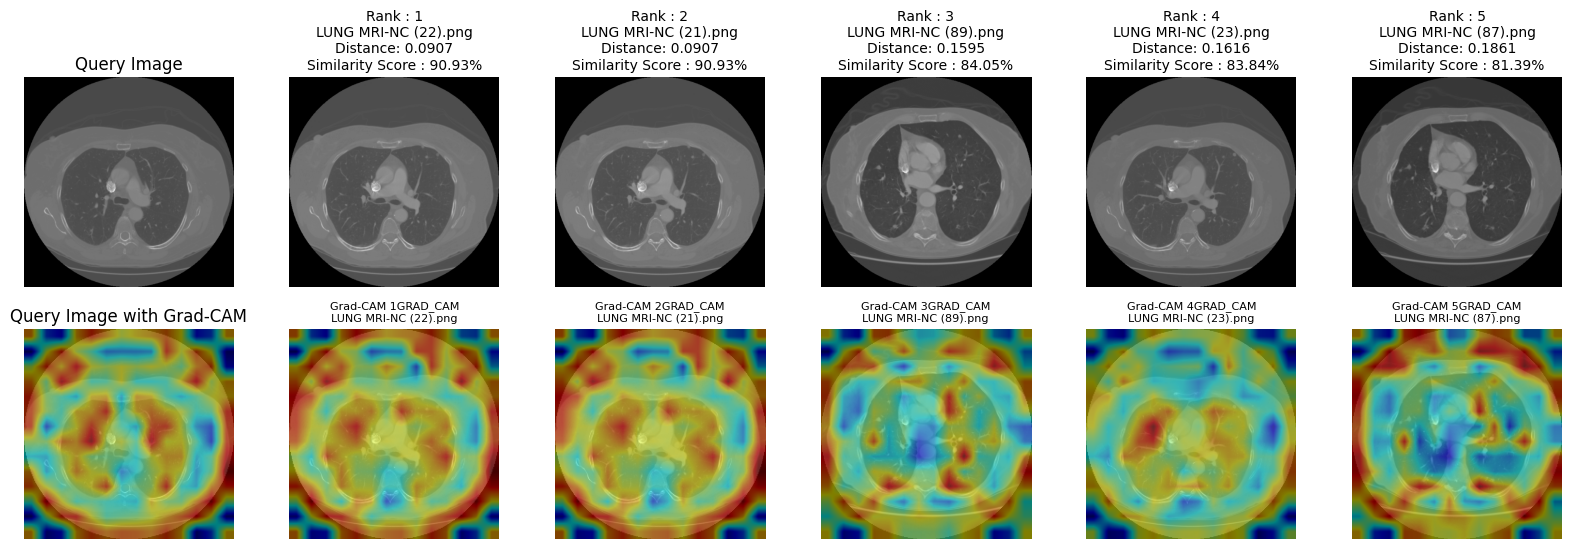

Search operation completed successfully.
Rank: 1,Image: LUNG MRI-NC (22).png, Distance: 0.0907435417175293, Similarity Score: 90.93%
Rank: 2,Image: LUNG MRI-NC (21).png, Distance: 0.0907435417175293, Similarity Score: 90.93%
Rank: 3,Image: LUNG MRI-NC (89).png, Distance: 0.1594698429107666, Similarity Score: 84.05%
Rank: 4,Image: LUNG MRI-NC (23).png, Distance: 0.16163158416748047, Similarity Score: 83.84%
Rank: 5,Image: LUNG MRI-NC (87).png, Distance: 0.18612957000732422, Similarity Score: 81.39%


In [25]:
nprobe = 1  # Number of clusters to search in FAISS index
top_k = 5 #Number of top results to retrieve
if __name__ == "__main__":
    # task = "index"  # Change to "Search" or indes
    task = "search"
    print("start of exection from the __main__ fuuction")
    if task.lower() == "index":
        
        print("Indexing the Data")
        
        # Folder_path = "vit_dataset"        
        Folder_path ="both_C_and_NC"
        # Step 1 : Preproecess
        all_tensors, all_metadata = preprocess_images_in_folder(Folder_path)
        if len(all_tensors) == 0:
            print("No images found to process. Exiting.")
            exit()
        
        # Step 2: Feature Extraction
            # Load ViT model
        vit_model = load_vit_model()

        # Extract features
        features = extract_features(vit_model, all_tensors)
        print(f"Extracted features for {len(features)} images.")
        # Optional: Save model
        save_model(vit_model)

        # Optional: Evaluate on one image
        # evaluate_feature_extractor(vit_model, all_tensors[0])
        
        if len(all_tensors) > 0:
            evaluate_feature_extractor(vit_model, all_tensors[0])
        else:
            print("No images available to evaluate.")
        
        # Step 3: Create FAISS Index
            # Build FAISS index 
        index, feature_matrix = create_faiss_index(features)
        
        # step 4: Save FAISS index and metadata
        # Save FAISS index and metadata
        save_faiss_index(index, "vit_ivf.index")
        # save_faiss_index(index,"vit_features.index")  wrong parameter given .index
        save_metadata(all_metadata, "vit_metadata.json")

        # save_metadata(all_metadata, "vit_metadata.json") wrong parameter given .json
        print(f"Indexed  {len(features)} images using ViT-B-16 with ivf")
        # print(f"Total number of images indexed: {len(index)}")
        print(f"Total number of metadata saved: {len(all_metadata)}")
        
        print("Feature extraction and Indexing operation completed successfully.")
        
    elif task.lower() == "search":
        # from this code onwards it is for search operation
        print("Starting search operation...")
        
        
        #  QUERY IMAGE PATH
        
        # Query images may present in DB
        
        # query_image_path ="query_images/Lung MRI-NC (7).png"
        # query_image_path ="query_images/Lung MRI-NC (16).png"
        # query_image_path = "query_images/Lung MRI (2).png"
        
        # Query images may not be present in DB
        
        # query_image_path = "query_images/tiger_query_image.jpeg"
        
        # query_image_path ="query_images/Lung MRI NC (150).png"
        query_image_path ="query_images/Lung MRI NC (151).png"
        # query_image_path ="query_images/Lung MRI NC (153).png"
        # query_image_path = "query_images/Lung MRI (752).png"
        # query_image_path = "query_images/Lung MRI (753).png"
        # query_image_path = "query_images/Lung MRI (760).png"


        # END QUERY IMAGE PATH
        
        
        if not os.path.exists(query_image_path):
            print(f"Query image '{query_image_path}' does not exist. Exiting.")
            exit()
        
        # Load the saved model
        vit_model = load_saved_model("vit_b16_feature_extractor.pth")
        
        # Preprocess the query image
        query_tensor = preprocess_query_image(query_image_path)
        query_feature = extract_query_features(vit_model, query_tensor)
        
        # Load the FAISS index and metadata
        faiss_index = load_faiss_index("vit_ivf.index")
        metadata = load_metadata("vit_metadata.json")
        
        
       
        # perform the search operation
        top_k_results = search_faiss_index(query_feature, faiss_index, metadata,top_k=top_k, nprobe=nprobe)
        
        # Print the search results
        print(f"Search Results: \n Top{len(top_k_results)} matches for query image '{Path(query_image_path).name}':")
        # display_results(query_image_path, top_k_results)
        display_query_and_gradcam_results(query_image_path, top_k_results, vit_model)
        print("Search operation completed successfully.")
        for result in top_k_results:
            print(f"Rank: {result['rank']},Image: {result['image_name']}, Distance: {result['distance']}, Similarity Score: {result['similarity_score']*100:.2f}%")
    else:
        print("Invalid task. Please choose 'Index' or 'Search'.")
        # End of the __main__ function

work on number of clusters ....++
nprobe and nlist
